In [1]:
import torch
from torch import nn
import random,numpy
import numpy as np
from copy import deepcopy
from game import Game, Move, RandomPlayer, MyPlayer,translate_number_to_position_direction,translate_number_to_position,TrainedPlayer
import torch.nn.init as init

In [2]:
class QuixoNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5*5, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 44),
        )
        for layer in self.linear_relu_stack:
                if isinstance(layer, nn.Linear):
                    init.xavier_uniform_(layer.weight)
                    layer.bias.data.fill_(0.01) # bias is initialized to 0.01 

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    

## Training the agent

In [3]:
## Constants definition
num_iterations = 500
num_matches = 2
max_dim_replay_buff = 778
time_to_update = 30
gamma = 0.485
batch_size=351
# potentially also the learning rate

device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [4]:
class ReplayBuffer:    
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size        
        self.buffer = []
        self.position = 0
        
    def add_experience(self, experience):        
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(experience)        
        else:
            self.buffer[self.position] = experience        
            self.position = (self.position + 1) % self.buffer_size
            
    def sample_batch(self, batch_size):
        batch_indices = np.random.choice(len(self.buffer), batch_size, replace=True)
        batch = [self.buffer[i] for i in batch_indices]
        return batch

In [5]:


print(1.0*(0.99**(200)))


0.13397967485796172


In [6]:
from game import Player
from tqdm import tqdm


def training(player1: 'Player', player2: 'Player'):
    loss_tot = []
    taboo_set = set()

    
    replay_buff = ReplayBuffer(max_dim_replay_buff) # replay buffer, from which we sample for BATCH learning
    # inizializza i modelli -> passali per parametro
    torch.set_grad_enabled(True)
    

    
    for step in tqdm(range(num_iterations), desc="Training Iterations"):  
        # we fill the replay buffer with experiences made with matches
        #player1.step=step
        for match in range(num_matches):
            # lo uso solo in inferenza
            # gioca una intera partita qui dentro e per ogni mossa, metti l'experience dentro il ReplayBuffer
            # ...
            # ... qui descrivere come viene effettivamente usata la rete neurale (magari impacchettarla in qualche funzione)
            winner = -1
            g = Game()
            #g.current_player_idx = match%2
            g.current_player_idx = 1

            #player1 = MyPlayer()
            #player2 = RandomPlayer()
            players = [player1, player2]

            go = False # serve a calcolare lo stato successivo per il calcolo del target

            while winner < 0:
                    g.current_player_idx += 1
                    g.current_player_idx %= len(players)
                    prev_state=deepcopy(g)
                    from_pos, slide = players[g.current_player_idx].make_move(g)
                    
                    if g.current_player_idx==0:
                        ##l'azione è il valore del q-value quindi un numero? o la posizione in questo caso
                        ##in quel caso replay_row=(prev_state.get_board,GeneratorNet((prev_state.get_board),g.get_board,reward)
                        reward=g.compute_reward(from_pos, slide)
                        go = True
                        #io qua dentro x ogni row voglio i 44 output della mia rete
                        
                        #replay_row=(prev_state.get_flat_board(),player1.last_action_number, deepcopy(g), reward)

                        # faccio fare una mossa all'avversario e poi faccio il max action sul nuovo stato che mi ritorna
                        
                    elif go and g.current_player_idx==1:
                        if (tuple(prev_state.get_flat_board()), player1.last_action_number, tuple(deepcopy(g).get_flat_board())) not in taboo_set :
                            replay_row=(prev_state.get_flat_board(), player1.last_action_number, deepcopy(g), reward, reward==1)
                            taboo_set.add((tuple(prev_state.get_flat_board()),player1.last_action_number, tuple(deepcopy(g).get_flat_board())))
                            #eliminato last_action da replay row?? Non dovrebbe servire
                            replay_buff.add_experience(replay_row)


                    if g.check_winner() != -1:
                        break
            
            # replay_buffer.push(...) per ogni transizione di stato osservata ()
            # restituisci il risultato sotto forma di tupla (st, a, st+1, r) - (State, action, next_state, reward)
            
        # Now we sample a batch of data from the ReplayBuffer in order to train the Agent
        batch_to_train = replay_buff.sample_batch(batch_size)
      
        #divide the batch
        state_batch, action_num, next_state_batch, reward, done = zip(*batch_to_train) 

        #forward the Generator
        q_values = player1.GeneratorNet(torch.tensor(state_batch, dtype=torch.float32)).to(player1.device)
        q_values_target = torch.zeros(batch_size, 44).to(player1.device)


        #update q_values target by using Bellman Equation  
        for i in range(batch_size): 
            if done[i] == False:
                q_values_target[i, action_num[i]] = reward[i] + gamma * torch.tensor(player1.compute_target(next_state_batch[i])).to(player1.device).item()
            else:
               q_values_target[i, action_num[i]] = reward[i] 
          
        player1.optimizer.zero_grad()
        loss_curr=player1.criterion(q_values,q_values_target).to(player1.device)
        loss_curr.backward()
    
        player1.optimizer.step()

        loss_tot.append(loss_curr)
      
        if (step % time_to_update) == 0:
            # update the parameter of the TargetNet
            player1.copy_params_TargetNet()
            
       
        #printa come varia 
   
    return player1.GeneratorNet.state_dict(), loss_tot
            
      

In [7]:
player1 = MyPlayer()
player2 = RandomPlayer()
TrainedGeneratorNet = TrainedPlayer()


trained_model_params, loss_tot = training(player1, player2)
TrainedGeneratorNet.GeneratorNet.load_state_dict(trained_model_params)# TRAINED NETWORK to use in INFERENCE PHASE

Training Iterations:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\chito\AppData\Local\Temp\ipykernel_21056\2494122676.py:73: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  q_values = player1.GeneratorNet(torch.tensor(state_batch, dtype=torch.float32)).to(player1.device)
Training Iterations: 100%|██████████| 500/500 [02:02<00:00,  4.08it/s]


<All keys matched successfully>

## Inference

In [8]:
wins = 0
losts = 0
draws = 0
num_match_test = 100

for step in tqdm(range(num_match_test),desc="Game"):
    player=RandomPlayer()
    g=Game()
    #g.current_player_idx = step%2
    g.current_player_idx += 1
    winner=g.play(TrainedGeneratorNet,player)
    if winner==0:
        wins+=1
       
    if winner==1:
        losts+=1
        
    if winner ==-1:
        draws+=1

print(f"Accuracy: {(wins/num_match_test)*100}")
print(f"Wins: {wins} - Losts: {losts} - Draws {draws}")



Game: 100%|██████████| 100/100 [00:00<00:00, 140.23it/s]

Accuracy: 95.0
Wins: 95 - Losts: 5 - Draws 0


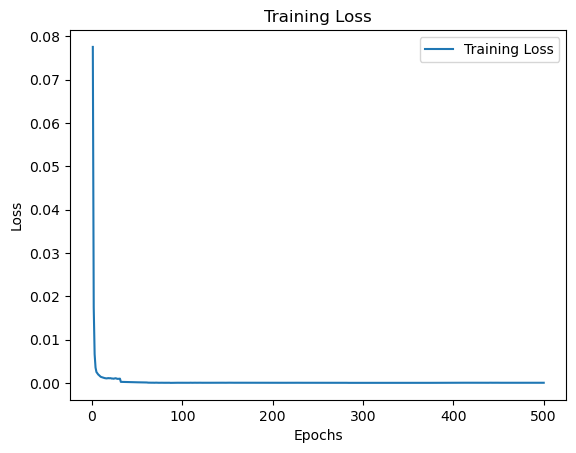

In [9]:
from matplotlib import pyplot as plt

vals = [el.detach().numpy() for el in loss_tot]
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, len(loss_tot) + 1)

# Plot and label the training and validation loss values
plt.plot(epochs, vals, label='Training Loss')

# Add title and axes labels
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plot
plt.legend()
plt.show()

In [10]:
torch.save(TrainedGeneratorNet.GeneratorNet.state_dict(), 'model_weights.pth')

In [11]:
player1 = MyPlayer()
player2 = RandomPlayer()
TrainedGeneratorNet = TrainedPlayer()
TrainedGeneratorNet.GeneratorNet.load_state_dict(torch.load('model_weights.pth'))

wins = 0
losts = 0
draws = 0
num_match_test = 100

for step in tqdm(range(num_match_test),desc="Game"):
    player=RandomPlayer()
    g=Game()
    #g.current_player_idx = step%2
    g.current_player_idx += 1
    winner=g.play(TrainedGeneratorNet,player)
    if winner==0:
        wins+=1
       
    if winner==1:
        losts+=1
        
    if winner ==-1:
        draws+=1

print(f"Accuracy: {(wins/num_match_test)*100}")

Game:   3%|▎         | 3/100 [00:00<00:03, 27.53it/s]

Game: 100%|██████████| 100/100 [00:00<00:00, 140.47it/s]

Accuracy: 89.0
